## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [2,5,8]

In [8]:
### 迴圈範例
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 8s 156us/step - loss: 1.9712 - accuracy: 0.3253 - val_loss: 1.9544 - val_accuracy: 0.3199
Epoch 10/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.9450 - accuracy: 0.3331 - val_loss: 1.9458 - val_accuracy: 0.3253
Epoch 11/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.9217 - accuracy: 0.3396 - val_loss: 1.9364 - val_accuracy: 0.3292
Epoch 12/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.9006 - accuracy: 0.3447 - val_loss: 1.9271 - val_accuracy: 0.3311
Epoch 13/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.8818 - accuracy: 0.3508 - val_loss: 1.9180 - val_accuracy: 0.3353
Epoch 14/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.8660 - accuracy: 0.3558 - val_loss: 1.9086 - val_accuracy: 0.3391
Epoch 15/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.8498 - accuracy: 0.3596 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 179us/step - loss: 2.9881 - accuracy: 0.1152 - val_loss: 2.2876 - val_accuracy: 0.1621
Epoch 2/25
50000/50000 [==============================] - 8s 156us/step - loss: 2.5817 - accuracy: 0.1813 - val_loss: 2.2416 - val_accuracy: 0.1709
Epoch 3/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.3812 - accuracy: 0.2254 - val_loss: 2.1930 - val_accuracy: 0.1963
Epoch 4/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.2666 - accuracy: 0.2517 - val_loss: 2.1394 - val_accuracy: 0.2333
Epoch 5/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.1883 - accuracy: 0.2698 - val_loss: 2.0897 - val_accuracy: 0.2597
Epoch 6/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.1292 - accuracy: 0.2847 - val_loss: 2.0505 - val_accuracy: 0.2782
Epoch 7/25
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 7s 142us/step - loss: 1.7861 - accuracy: 0.3786 - val_loss: 1.8522 - val_accuracy: 0.3527
Epoch 21/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.7759 - accuracy: 0.3807 - val_loss: 1.8419 - val_accuracy: 0.3563
Epoch 22/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.7659 - accuracy: 0.3832 - val_loss: 1.8361 - val_accuracy: 0.3586
Epoch 23/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.7562 - accuracy: 0.3871 - val_loss: 1.8266 - val_accuracy: 0.3615
Epoch 24/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.7473 - accuracy: 0.3901 - val_loss: 1.8191 - val_accuracy: 0.3640
Epoch 25/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.7385 - accuracy: 0.3922 - val_loss: 1.8124 - val_accuracy: 0.3663
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 8
Model: "model_6"
___________________________________________

Epoch 5/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.1458 - accuracy: 0.2767 - val_loss: 2.0449 - val_accuracy: 0.2717
Epoch 6/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.0916 - accuracy: 0.2905 - val_loss: 2.0106 - val_accuracy: 0.2875
Epoch 7/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.0491 - accuracy: 0.3013 - val_loss: 1.9833 - val_accuracy: 0.3028
Epoch 8/25
50000/50000 [==============================] - 8s 152us/step - loss: 2.0135 - accuracy: 0.3108 - val_loss: 1.9665 - val_accuracy: 0.3135
Epoch 9/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.9834 - accuracy: 0.3205 - val_loss: 1.9501 - val_accuracy: 0.3204
Epoch 10/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.9555 - accuracy: 0.3284 - val_loss: 1.9379 - val_accuracy: 0.3280
Epoch 11/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.9316 - accuracy: 0.3355 - va

Epoch 25/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.7547 - accuracy: 0.3907 - val_loss: 1.8245 - val_accuracy: 0.3680
Numbers of exp: 8, reduce_factor: 0.80, reduce_patient: 8
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
__________________________________________________

50000/50000 [==============================] - 9s 176us/step - loss: 0.9486 - accuracy: 0.6730 - val_loss: 1.3824 - val_accuracy: 0.5087
Epoch 10/25
50000/50000 [==============================] - 9s 176us/step - loss: 0.9260 - accuracy: 0.6809 - val_loss: 1.3371 - val_accuracy: 0.5316
Epoch 11/25
50000/50000 [==============================] - 8s 170us/step - loss: 0.9031 - accuracy: 0.6895 - val_loss: 1.3368 - val_accuracy: 0.5317
Epoch 12/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.8814 - accuracy: 0.7010 - val_loss: 1.3279 - val_accuracy: 0.5304
Epoch 13/25
50000/50000 [==============================] - 9s 176us/step - loss: 0.8610 - accuracy: 0.7074 - val_loss: 1.3754 - val_accuracy: 0.5265
Epoch 14/25
50000/50000 [==============================] - 8s 169us/step - loss: 0.8408 - accuracy: 0.7155 - val_loss: 1.3558 - val_accuracy: 0.5314

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 15/25
50000/50000 [===========

50000/50000 [==============================] - 9s 182us/step - loss: 2.6491 - accuracy: 0.1655 - val_loss: 2.6569 - val_accuracy: 0.1668
Epoch 25/25
50000/50000 [==============================] - 9s 174us/step - loss: 2.6508 - accuracy: 0.1647 - val_loss: 2.6572 - val_accuracy: 0.1667
Numbers of exp: 11, reduce_factor: 0.20, reduce_patient: 8
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
___________________________________________

50000/50000 [==============================] - 9s 177us/step - loss: 3.0120 - accuracy: 0.0964 - val_loss: 2.5945 - val_accuracy: 0.1004
Epoch 7/25
50000/50000 [==============================] - 9s 172us/step - loss: 3.0130 - accuracy: 0.0962 - val_loss: 2.6627 - val_accuracy: 0.1008

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 8/25
50000/50000 [==============================] - 9s 171us/step - loss: 3.0134 - accuracy: 0.0968 - val_loss: 2.7279 - val_accuracy: 0.1007
Epoch 9/25
50000/50000 [==============================] - 9s 171us/step - loss: 3.0117 - accuracy: 0.0968 - val_loss: 2.7861 - val_accuracy: 0.1002
Epoch 10/25
50000/50000 [==============================] - 9s 171us/step - loss: 3.0120 - accuracy: 0.0966 - val_loss: 2.8365 - val_accuracy: 0.0995
Epoch 11/25
50000/50000 [==============================] - 9s 172us/step - loss: 3.0119 - accuracy: 0.0973 - val_loss: 2.8791 - val_accuracy: 0.0988
Epoch 12/25
50000/50000 [==============================]

50000/50000 [==============================] - 8s 156us/step - loss: 3.0147 - accuracy: 0.1057 - val_loss: 3.0186 - val_accuracy: 0.1055
Numbers of exp: 14, reduce_factor: 0.50, reduce_patient: 8
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 9s 184us/step - loss: 3.0033 - accuracy: 0.1049 - val_loss: 2.8456 - val_accuracy: 0.1021
Epoch 11/25
50000/50000 [==============================] - 10s 197us/step - loss: 3.0032 - accuracy: 0.1049 - val_loss: 2.8874 - val_accuracy: 0.1023
Epoch 12/25
50000/50000 [==============================] - 9s 185us/step - loss: 3.0027 - accuracy: 0.1048 - val_loss: 2.9204 - val_accuracy: 0.1022
Epoch 13/25
50000/50000 [==============================] - 9s 174us/step - loss: 3.0032 - accuracy: 0.1051 - val_loss: 2.9454 - val_accuracy: 0.1016
Epoch 14/25
50000/50000 [==============================] - 9s 177us/step - loss: 3.0029 - accuracy: 0.1051 - val_loss: 2.9643 - val_accuracy: 0.1014
Epoch 15/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0036 - accuracy: 0.1057 - val_loss: 2.9775 - val_accuracy: 0.1007
Epoch 16/25
50000/50000 [==============================] - 9s 177us/step - loss: 3.0024 - accuracy: 0.105

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 238us/step - loss: 3.1894 - accuracy: 0.0875 - val_loss: 2.3522 - val_accuracy: 0.1008
Epoch 2/25
50000/50000 [==============================] - 9s 181us/step - loss: 3.1887 - accuracy: 0.0875 - val_loss: 2.3918 - val_accuracy: 0.1028
Epoch 3/25
50000/50000 [==============================] - 9s 183us/step - loss: 3.1903 - accuracy: 0.0875 - val_loss: 2.4563 - val_accuracy: 0.1025
Epoch 4/25
50000/50000 [==============================] - 9s 179us/step - loss: 3.1899 - accuracy: 0.0880 - val_loss: 2.5282 - val_accuracy: 0.1038
Epoch 5/25
50000/50000 [==============================] - 9s 181us/step - loss: 3.1897 - accuracy: 0.0881 - val_loss: 2.6016 - val_accuracy: 0.1001
Epoch 6/25
50000/50000 [==============================] - 9s 180us/step - loss: 3.1901 - accuracy: 0.0869 - val_loss: 2.6758 - val_accuracy: 0.0989
Epoch 7/25
50000/50000 [==============================] - 9s 


Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 19/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.8718 - accuracy: 0.7061 - val_loss: 1.2960 - val_accuracy: 0.5470
Epoch 20/25
50000/50000 [==============================] - 9s 182us/step - loss: 0.8714 - accuracy: 0.7079 - val_loss: 1.2961 - val_accuracy: 0.5470

Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 21/25
50000/50000 [==============================] - 9s 180us/step - loss: 0.8712 - accuracy: 0.7072 - val_loss: 1.2965 - val_accuracy: 0.5468
Epoch 22/25
50000/50000 [==============================] - 9s 175us/step - loss: 0.8713 - accuracy: 0.7065 - val_loss: 1.2966 - val_accuracy: 0.5473

Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 23/25
50000/50000 [==============================] - 9s 177us/step - loss: 0.8706 - accuracy: 0.7061 - val_loss: 1.2968 - val_accuracy: 0.5470
Epoch 24/25

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 243us/step - loss: 3.1362 - accuracy: 0.0861 - val_loss: 2.3712 - val_accuracy: 0.0937
Epoch 2/25
50000/50000 [==============================] - 10s 198us/step - loss: 3.1364 - accuracy: 0.0872 - val_loss: 2.4169 - val_accuracy: 0.0850
Epoch 3/25
50000/50000 [==============================] - 10s 197us/step - loss: 3.1358 - accuracy: 0.0869 - val_loss: 2.4805 - val_accuracy: 0.0808
Epoch 4/25
50000/50000 [==============================] - 10s 197us/step - loss: 3.1361 - accuracy: 0.0872 - val_loss: 2.5560 - val_accuracy: 0.0799
Epoch 5/25
50000/50000 [==============================] - 10s 204us/step - loss: 3.1359 - accuracy: 0.0864 - val_loss: 2.6403 - val_accuracy: 0.0804
Epoch 6/25
50000/50000 [==============================] - 10s 197us/step - loss: 3.1366 - accuracy: 0.0869 - val_loss: 2.7267 - val_accuracy: 0.0825
Epoch 7/25
50000/50000 [==============================] 

50000/50000 [==============================] - 10s 202us/step - loss: 3.0570 - accuracy: 0.0951 - val_loss: 3.0534 - val_accuracy: 0.0965
Epoch 20/25
50000/50000 [==============================] - 10s 203us/step - loss: 3.0586 - accuracy: 0.0941 - val_loss: 3.0551 - val_accuracy: 0.0967
Epoch 21/25
50000/50000 [==============================] - 10s 203us/step - loss: 3.0579 - accuracy: 0.0944 - val_loss: 3.0566 - val_accuracy: 0.0967
Epoch 22/25
50000/50000 [==============================] - 10s 201us/step - loss: 3.0573 - accuracy: 0.0948 - val_loss: 3.0574 - val_accuracy: 0.0968
Epoch 23/25
50000/50000 [==============================] - 10s 202us/step - loss: 3.0585 - accuracy: 0.0940 - val_loss: 3.0578 - val_accuracy: 0.0970
Epoch 24/25
50000/50000 [==============================] - 10s 201us/step - loss: 3.0582 - accuracy: 0.0942 - val_loss: 3.0577 - val_accuracy: 0.0971
Epoch 25/25
50000/50000 [==============================] - 10s 205us/step - loss: 3.0567 - accuracy: 0.0948 - va

50000/50000 [==============================] - 10s 210us/step - loss: 3.0057 - accuracy: 0.1077 - val_loss: 2.4258 - val_accuracy: 0.1063
Epoch 4/25
50000/50000 [==============================] - 11s 227us/step - loss: 3.0067 - accuracy: 0.1072 - val_loss: 2.4776 - val_accuracy: 0.1067
Epoch 5/25
50000/50000 [==============================] - 11s 210us/step - loss: 3.0048 - accuracy: 0.1070 - val_loss: 2.5376 - val_accuracy: 0.1093
Epoch 6/25
50000/50000 [==============================] - 13s 262us/step - loss: 3.0056 - accuracy: 0.1082 - val_loss: 2.6024 - val_accuracy: 0.1088
Epoch 7/25
50000/50000 [==============================] - 11s 216us/step - loss: 3.0054 - accuracy: 0.1071 - val_loss: 2.6675 - val_accuracy: 0.1069
Epoch 8/25
50000/50000 [==============================] - 11s 218us/step - loss: 3.0048 - accuracy: 0.1074 - val_loss: 2.7285 - val_accuracy: 0.1058
Epoch 9/25
50000/50000 [==============================] - 11s 229us/step - loss: 3.0066 - accuracy: 0.1074 - val_loss

50000/50000 [==============================] - 10s 205us/step - loss: 3.0019 - accuracy: 0.1098 - val_loss: 2.9999 - val_accuracy: 0.1076
Epoch 23/25
50000/50000 [==============================] - 10s 209us/step - loss: 3.0033 - accuracy: 0.1099 - val_loss: 3.0004 - val_accuracy: 0.1076
Epoch 24/25
50000/50000 [==============================] - 11s 216us/step - loss: 3.0030 - accuracy: 0.1103 - val_loss: 3.0006 - val_accuracy: 0.1077
Epoch 25/25
50000/50000 [==============================] - 12s 238us/step - loss: 3.0023 - accuracy: 0.1103 - val_loss: 3.0006 - val_accuracy: 0.1076
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____

50000/50000 [==============================] - 11s 219us/step - loss: 3.0471 - accuracy: 0.1116 - val_loss: 2.6804 - val_accuracy: 0.1272
Epoch 7/25
50000/50000 [==============================] - 11s 224us/step - loss: 3.0482 - accuracy: 0.1097 - val_loss: 2.7457 - val_accuracy: 0.1229
Epoch 8/25
50000/50000 [==============================] - 11s 220us/step - loss: 3.0485 - accuracy: 0.1103 - val_loss: 2.8037 - val_accuracy: 0.1220
Epoch 9/25
50000/50000 [==============================] - 11s 224us/step - loss: 3.0476 - accuracy: 0.1116 - val_loss: 2.8535 - val_accuracy: 0.1214
Epoch 10/25
50000/50000 [==============================] - 11s 230us/step - loss: 3.0478 - accuracy: 0.1104 - val_loss: 2.8954 - val_accuracy: 0.1188
Epoch 11/25
50000/50000 [==============================] - 11s 225us/step - loss: 3.0479 - accuracy: 0.1098 - val_loss: 2.9298 - val_accuracy: 0.1175
Epoch 12/25
50000/50000 [==============================] - 12s 231us/step - loss: 3.0473 - accuracy: 0.1116 - val_l

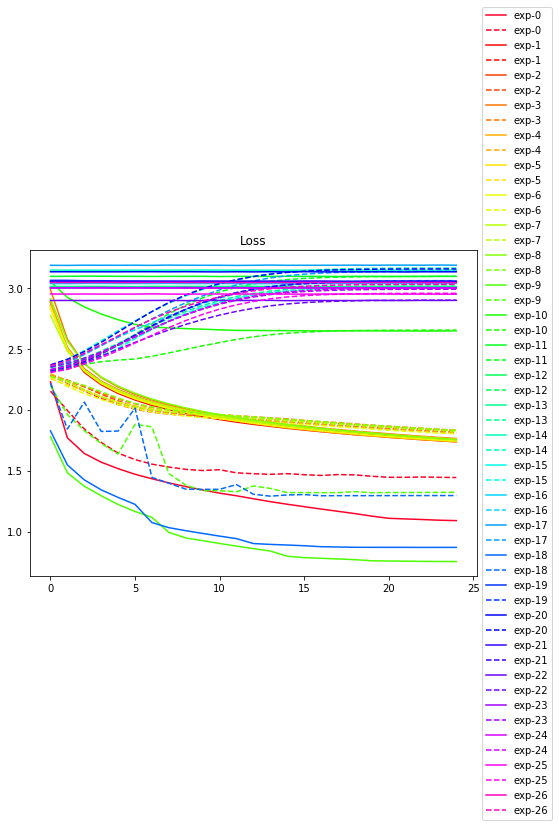

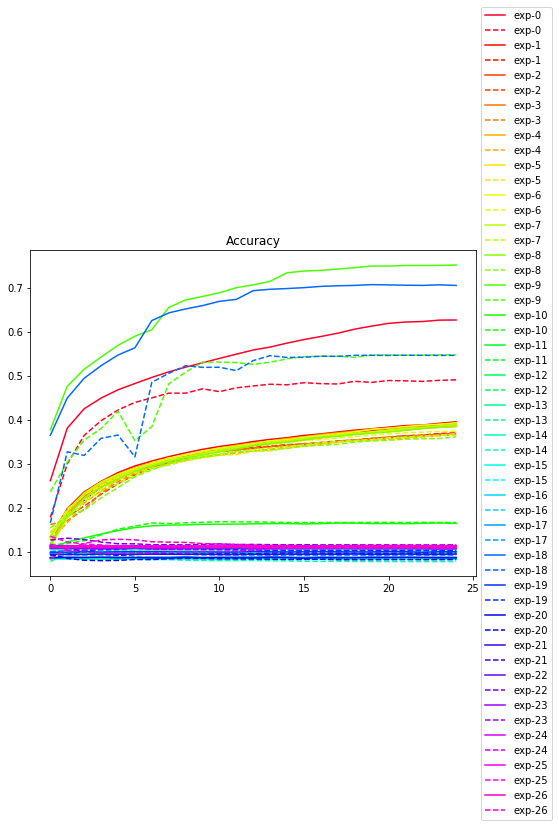

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()